In [1]:
from keras.models import load_model
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

import pickle 
import numpy as np
import pandas as pd
import scipy
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report

Using TensorFlow backend.


In [2]:
model = load_model('/data/Data/yntn/model_LSTM_w10_100MB.hdf5')

In [3]:
df = pd.read_csv ('/data/Data/yntn/data_labeled_10M.csv')

In [4]:
label_tag = (list(set (df.label)))
label_tag.sort()
cutdata = []
for i in range (len(label_tag)):
    df_go = df[df.label == label_tag[i]].head(100000)    
    cutdata.append(df_go)
go = pd.concat(cutdata, axis = 0)

In [5]:
word_dict = pickle.load (open("/data/Data/yntn/word_embedding_vec.pkl",'rb'))

In [6]:
tok = pickle.load (open("/data/Data/yntn/emotion-detection-from-text/tokenize.pkl",'rb'))

In [7]:
Y = go.label
le = LabelEncoder()
Y = le.fit_transform(Y)

In [8]:
def detect_emotion(arr):
    max_words = 88860
    max_len = 30
    test = [str(s) for s in arr]
    sequences = tok.texts_to_sequences(test)
    sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)
    emotion = []
    print(    sequences_matrix.shape)
    rs = model.predict( sequences_matrix , batch_size=1024, verbose=1, steps=None)
    return (rs)

In [9]:
X = go.text
Y = go.label

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.2, random_state = 11)

In [11]:
test_list = X_test.tolist()
label_list = le.transform(Y_test.tolist())

In [12]:
final = detect_emotion(test_list)

(373308, 30)
373308/373308 [==============================] - 7s 18us/step


In [13]:
final = np.argmax(final,axis=1)

TÍNH F1

In [14]:
precision_score(label_list, final, average='macro')

/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.02906467597436709

In [15]:
recall_score(label_list, final, average='macro')

0.03144981751794916

In [16]:
f1_score(label_list, final, average='macro')

/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.020681530307209896

CONFUSION MATRIX

In [17]:
cm = confusion_matrix(label_list, final)

In [18]:
import seaborn

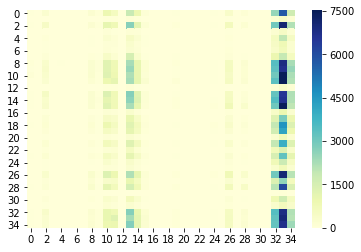

In [19]:
seaborn.heatmap(cm, cmap="YlGnBu")

In [20]:
x=[sum(cm[i]) - cm[i,i] for i in range (35)]
y=[sum(cm[i]) for i in range (35)]

In [21]:
cm_pcnt  = [cm[i]/y[i]*100 for i in range (35)]

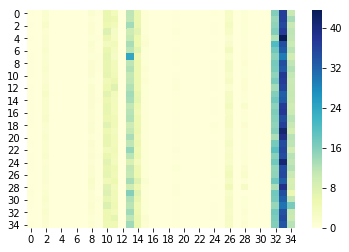

In [22]:
seaborn.heatmap(cm_pcnt, cmap="YlGnBu")

CORRELATION

In [23]:
tag_label = [(str(le.inverse_transform([i])[0])) for i in range(35)]

In [42]:
cls_report = classification_report(label_list, final, target_names=tag_label, output_dict=False)

/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [43]:
outfile = "classification_report.txt"
with open(outfile, "w") as f:
    f.write(cls_report)

In [27]:
arr_f1_score = []
arr_support = []
for i in range (35):    
    arr_f1_score.append(cls_report[tag_label[i]]['f1-score'])
    arr_support.append(cls_report[tag_label[i]]['support'])                   

In [28]:
np.corrcoef(arr_f1_score, arr_support)

array([[1.        , 0.76626728],
       [0.76626728, 1.        ]])

In [29]:
scipy.stats.spearmanr(arr_f1_score, arr_support)

SpearmanrResult(correlation=0.7884862245567703, pvalue=1.85966710976863e-08)

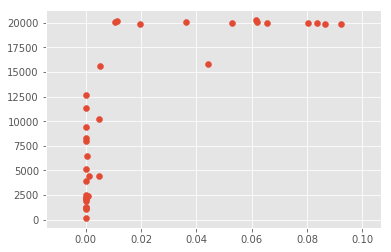

In [30]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')

plt.scatter(arr_f1_score, arr_support)
plt.show()

In [31]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt

In [32]:
with open("stop_word.txt",'r') as f :
    sw = f.readlines()
for i in range (len(sw)):
    sw[i] = sw[i].strip('\n')

In [39]:
def word_cloud_plot(text,label):    
    wordcloud = WordCloud().generate(text)
    wordcloud = WordCloud(background_color="white").generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.savefig("word_cloud_100MB/" + label +".png")

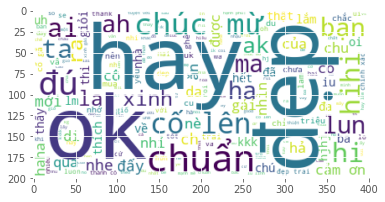

In [41]:
for i in range(35):
    data = df.text[df.label == tag_label[i]]
    text = " ".join(str(row) for row in data)   
    for j in range(len(sw)):
        text = text.replace(sw[j],'')
    if i == 4:
        text = text.replace('chị','')
    word_cloud_plot(text,tag_label[i])